In [58]:
library(tidyverse)
library(nycflights13)

## Review problem (from last lecture)
There are five cuts of diamond: Fair, Good, Very Good, Premium and Ideal. Within each type of cut we can compute the average weight. For example, the average weight of an Ideal diamond is 0.703 carats. If we do this for the other four types of cut we get five averages.

What is the average of these five numbers? In other words, what's the average of the average weight within each cut? 

#### Choices (avg. of averages)
1. $[0.5,0.75)$ cts.
2. $[0.75, 0.85)$ cts.
3. $[0.85, 0.9)$ cts.
4. $[0.9, 1.0)$ cts.

Is this number equal to the average weight when computed over the entire `diamonds` data set?

In [65]:
diamonds %>% group_by(cut) %>% summarize(m=mean(carat)) %>% summarize(mean(m))


  mean(m)  
1 0.7979397

# Lecture 05
Goals for this lecture:

* [Finish up `summarize()` and `count()`](#Wrapping-up-summarize())
* Learn to use [grouping for mutate and filter](#Grouped-mutates-and-filters) ([§5.7](http://r4ds.had.co.nz/transform.html#grouped-mutates-and-filters))
* Delve a little deeper into [pipes](#Pipes) ([§5.6.1](http://r4ds.had.co.nz/transform.html#combining-multiple-operations-with-the-pipe))
* [Summarize of §5](#Summary-of-§5)
* Start [visualizing distributions](#Visualizing-distributions) ([§7](http://r4ds.had.co.nz/exploratory-data-analysis.html))

## Wrapping up `summarize()`
One of the reasons for the `count()` shortcut is that it is always a good idea to add counts when do you a summary. This is because some groups may have very low numbers of observations, resulting in high variance for the summary statistics. For example, let's look at particular airplanes which have high delays, perhaps due to maintenance, etc:

In [68]:
# not_cancelled = flights %>% filter(!is.na(dep_delay), !is.na(arr_delay)) 
not_cancelled %>% group_by(tailnum) %>% summarise(delay = mean(arr_delay)) %>% top_n(5)

Selecting by delay


  tailnum delay
1 N587NW  264  
2 N844MH  320  
3 N851NW  219  
4 N911DA  294  
5 N922EV  276  

The top five most delayed planes experience an average delay of 4-5 hours! Clearly this is not realistic. The issue is that there are very few observations for each of these planes:

In [69]:
delays = not_cancelled %>% group_by(tailnum) %>% summarise(delay=mean(arr_delay), obs=n()) %>% print
#top_n(delays, 5, delay)

# A tibble: 4,037 x 3
   tailnum   delay   obs
   <chr>     <dbl> <int>
 1 D942DN   31.5       4
 2 N0EGMQ    9.98    352
 3 N10156   12.7     145
 4 N102UW    2.94     48
 5 N103US   -6.93     46
 6 N104UW    1.80     46
 7 N10575   20.7     269
 8 N105UW   -0.267    45
 9 N107US   -5.73     41
10 N108UW   -1.25     60
# ... with 4,027 more rows


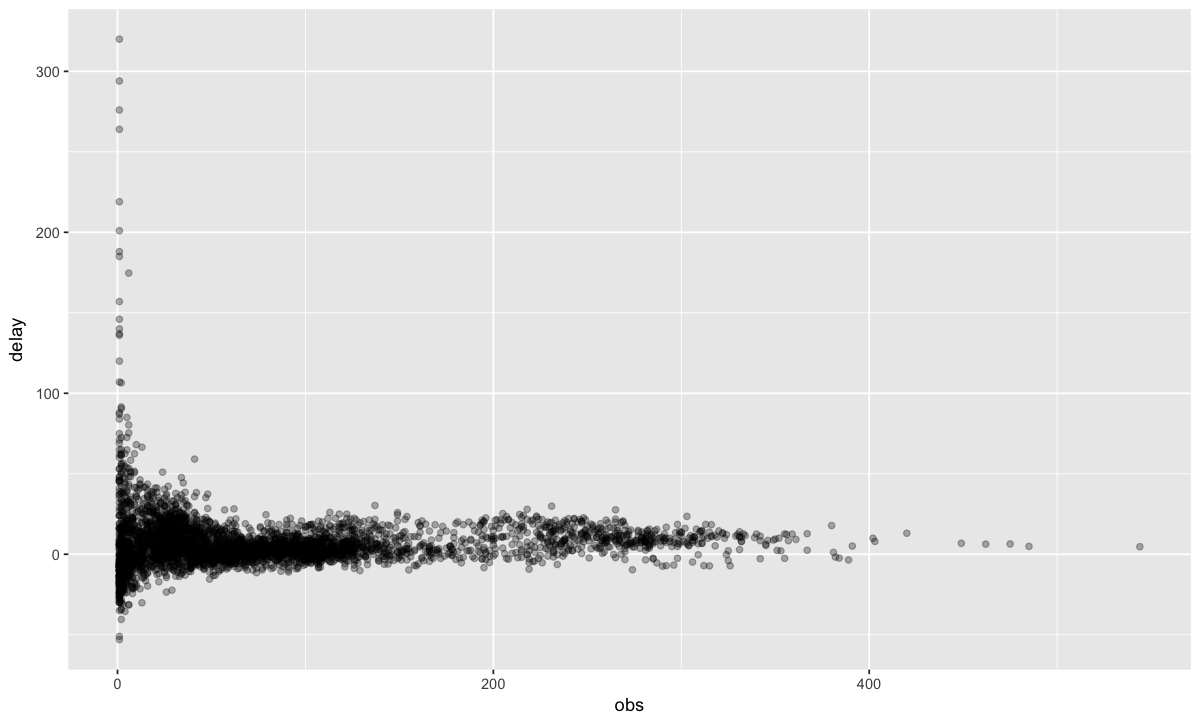

In [70]:
ggplot(delays) + geom_point(aes(x=obs, y=delay), alpha=.3) 

The solution is to filter to only those planes that had sufficiently many observations:

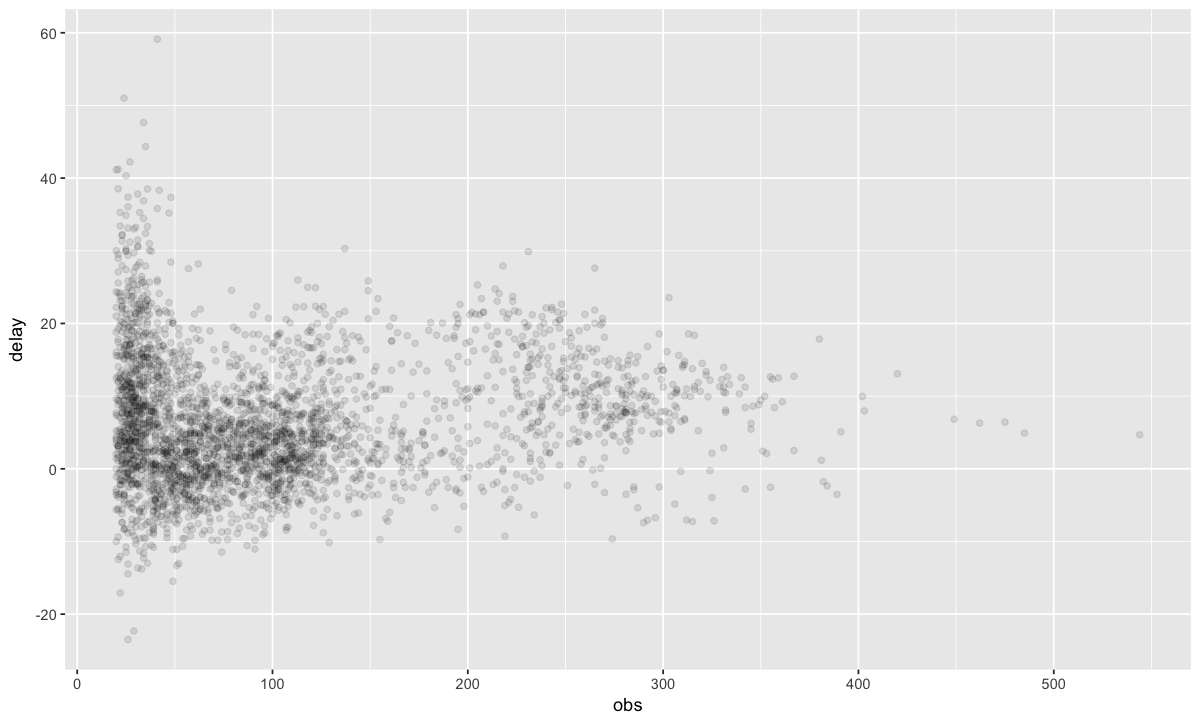

In [6]:
ggplot(filter(delays, obs >= 20)) + geom_point(aes(x=obs, y=delay), alpha=.1) 

Something similar occurs if we start sorting by an average: ignoring the standard error of the estimated average can cause spurious extreme values to rise to the top. Here's an example from baseball:

`geom_smooth()` using method = 'gam'


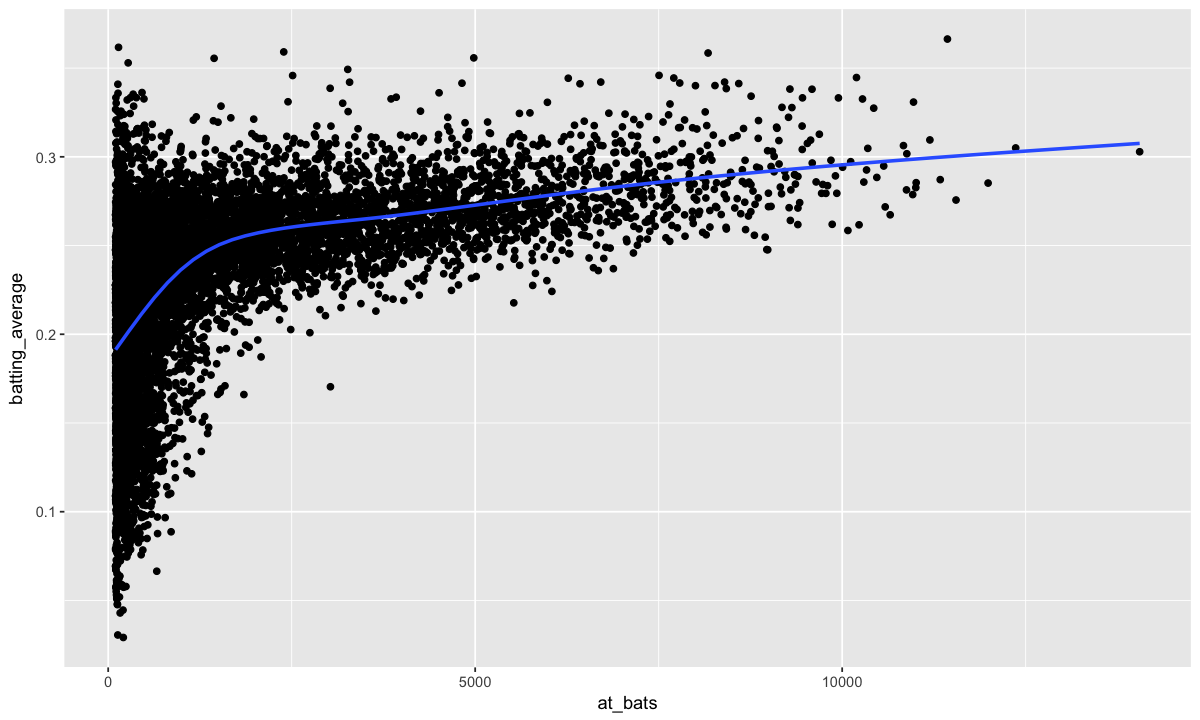

In [7]:
# Convert to a tibble so it prints nicely
# H = hits; AB = at bats
# ba =
batters <- as_tibble(Lahman::Batting) %>% group_by(playerID) %>% summarise(
    batting_average = sum(H, na.rm = TRUE) / sum(AB, na.rm = TRUE),
    at_bats = sum(AB, na.rm = TRUE) )
batters %>% filter(at_bats > 100) %>%
            ggplot(mapping = aes(x = at_bats, y = batting_average)) + 
                  geom_point() + geom_smooth(se = FALSE)

Clearly better players get more at-bats. Who are the best players? If we sort by batting average, we see:

In [8]:
batters %>% arrange(desc(batting_average)) %>% print

# A tibble: 18,915 x 3
   playerID  batting_average at_bats
   <chr>               <dbl>   <int>
 1 abramge01               1       1
 2 banisje01               1       1
 3 bartocl01               1       1
 4 bassdo01                1       1
 5 berrijo01               1       1
 6 birasst01               1       2
 7 bruneju01               1       1
 8 burnscb01               1       1
 9 cammaer01               1       1
10 campsh01                1       1
# ... with 18,905 more rows


To get a better estimate we should restrict to people who had at least 100 at-bats, say:

In [9]:
batters %>% arrange(desc(batting_average)) %>% filter(at_bats >= 1000) %>% print

# A tibble: 3,693 x 3
   playerID  batting_average at_bats
   <chr>               <dbl>   <int>
 1 cobbty01            0.366   11434
 2 barnero01           0.359    2392
 3 hornsro01           0.358    8173
 4 jacksjo01           0.356    4981
 5 meyerle01           0.356    1443
 6 odoulle01           0.349    3264
 7 delahed01           0.346    7505
 8 mcveyca01           0.346    2513
 9 speaktr01           0.345   10195
10 willite01           0.344    7706
# ... with 3,683 more rows


In [10]:
Lahman::playerInfo("cobbty01")

     playerID nameFirst nameLast
3183 cobbty01 Ty        Cobb    

### Challenge problem 1
Let's say an air carrier is *regional* if its average distance traveled per flight is less than 600 miles, with a standard deviation of less than 250 miles, *and* it has at least 500 flights. 

Which of these carriers are regional?

1. UA
2. MQ
3. 4E
4. DL
5. YV

In [77]:
summarize(group_by(flights, carrier), mu=mean(distance), sigma=sd(distance), count=n()) %>% 
              filter(mu <= 600, sigma < 250, count >= 500)


  carrier mu       sigma    count
1 MQ      569.5327 226.2287 26397
2 YV      375.0333 159.7196   601

### Some other examples of aggregation
Compute the number of unique destinations for each day of the month:

In [86]:
flights %>% group_by(month) %>% summarize(nd=n_distinct(dest)) %>% print

# A tibble: 12 x 2
   month    nd
   <int> <int>
 1     1    94
 2     2    92
 3     3    95
 4     4    93
 5     5    90
 6     6    93
 7     7    94
 8     8    93
 9     9    92
10    10    91
11    11    90
12    12    96


In [13]:
group_by(flights, day) %>% summarize(n_distinct(dest)) %>% print

# A tibble: 31 x 2
     day `n_distinct(dest)`
   <int>              <int>
 1     1                 96
 2     2                101
 3     3                 97
 4     4                 96
 5     5                100
 6     6                 99
 7     7                 96
 8     8                 95
 9     9                101
10    10                 97
# ... with 21 more rows


Dispersion of delays by carrier:

In [90]:
flights %>% group_by(carrier) %>% summarize(sd=sd(dep_delay, na.rm=T), iqr=IQR(dep_delay, na.rm=T))

   carrier sd       iqr
1  9E      45.90604 23 
2  AA      37.35486 10 
3  AS      31.36303 10 
4  B6      38.50337 17 
5  DL      39.73505 10 
6  EV      46.55235 30 
7  F9      58.36265 22 
8  FL      52.66160 21 
9  HA      74.10990  6 
10 MQ      39.18457 16 
11 OO      43.06599 13 
12 UA      35.71660 15 
13 US      28.05633  7 
14 VX      44.81510 12 
15 WN      43.34435 19 
16 YV      49.17227 30 

In [15]:
group_by(flights, carrier) %>% summarize(n=n(),
                                         dep_iqr=IQR(dep_delay, na.rm=T), 
                                         arr_iqr=IQR(arr_delay, na.rm=T)) %>% arrange(n)

   carrier n     dep_iqr arr_iqr
1  OO         32 13      22.00  
2  HA        342  6      30.50  
3  YV        601 30      40.25  
4  F9        685 22      40.00  
5  AS        714 10      34.00  
6  FL       3260 21      31.00  
7  VX       5162 12      31.00  
8  WN      12275 19      30.00  
9  9E      18460 23      36.00  
10 US      20536  7      23.00  
11 MQ      26397 16      31.00  
12 AA      32729 10      29.00  
13 DL      48110 10      28.00  
14 EV      54173 30      40.00  
15 B6      54635 17      31.00  
16 UA      58665 15      30.00  

What is the worst-performing air carrier (in terms of median departure delay) for each month of the year?

In [110]:
flights %>% group_by(carrier, month) %>% summarize(mdd=median(dep_delay, na.rm=T)) %>%
            group_by(month) %>% mutate(r=dense_rank(desc(mdd))) %>% filter(r == 1) % >% arrange(month)

   carrier month mdd  r
1  OO       1    67.0 1
2  EV       2     1.0 1
3  YV       3    15.5 1
4  YV       4     9.0 1
5  F9       5    13.5 1
6  OO       6    61.0 1
7  F9       7    16.0 1
8  OO       8    56.0 1
9  F9       9     2.0 1
10 FL      10     3.0 1
11 FL      11     6.0 1
12 WN      12     9.0 1

Again note the issue here with low observation counts. In case you are curious what these carrier codes represent (who not to fly), we can use a *table join* (to be discussed later) to figure it out:

In [17]:
most_delayed %>% left_join(airlines)

Joining, by = "carrier"


   carrier month mean_dep_delay obs  rank name                       
1  OO       1    67.00000          1 1    SkyWest Airlines Inc.      
2  F9       2    29.77083         49 1    Frontier Airlines Inc.     
3  YV       3    31.88889         18 1    Mesa Airlines Inc.         
4  YV       4    27.11111         38 1    Mesa Airlines Inc.         
5  F9       5    35.94828         58 1    Frontier Airlines Inc.     
6  OO       6    61.00000          2 1    SkyWest Airlines Inc.      
7  FL       7    41.16270        263 1    AirTran Airways Corporation
8  OO       8    64.00000          4 1    SkyWest Airlines Inc.      
9  FL       9    16.94882        255 1    AirTran Airways Corporation
10 YV      10    20.00000         66 1    Mesa Airlines Inc.         
11 FL      11    16.86634        202 1    AirTran Airways Corporation
12 EV      12    27.88718       4307 1    ExpressJet Airlines Inc.   

How does the situation change if we look at the median departure delay?

In [18]:
group_by(flights, carrier, month) %>% 
    summarize(median_dep_delay=median(dep_delay, na.rm=T), obs=n()) %>%
    group_by(month) %>% mutate(rank=min_rank(-median_dep_delay)) %>%
    arrange(month, rank) %>% filter(rank==1) %>% print

# A tibble: 12 x 5
# Groups:   month [12]
   carrier month median_dep_delay   obs  rank
   <chr>   <int>            <dbl> <int> <int>
 1 OO          1             67       1     1
 2 EV          2              1    3827     1
 3 YV          3             15.5    18     1
 4 YV          4              9      38     1
 5 F9          5             13.5    58     1
 6 OO          6             61       2     1
 7 F9          7             16      58     1
 8 OO          8             56       4     1
 9 F9          9              2      58     1
10 FL         10              3     236     1
11 FL         11              6     202     1
12 WN         12              9    1099     1


Compared to the mean, the median departure delay looks less extreme.

### Transformations in summaries
We can combine transformations and summaries to get perform more complicated queries on the data. The following summary looks at the number of early-morning departures by month:

In [117]:
# not_cancelled %>% group_by(month) %>% summarise(n_early = sum(dep_time < 500)) %>% print
not_cancelled %>% mutate(early = dep_time < 500) %>% select(month, dep_time, early) %>%
    group_by(month) %>% summarize(n_early=sum(early))

   month n_early
1   1     75    
2   2     84    
3   3    147    
4   4    148    
5   5    120    
6   6    219    
7   7    268    
8   8    135    
9   9     64    
10 10     43    
11 11     46    
12 12    127    

A red-eye (overnight) flight will have `dep_time > arr_time`. Here are the red-eyes by month:

In [120]:
not_cancelled %>% group_by(month) %>% mutate(redeye = dep_time > arr_time) %>% 
                  summarise(n_redeye = sum(redeye)) %>% print

# A tibble: 12 x 2
   month n_redeye
   <int>    <int>
 1     1      713
 2     2      631
 3     3      949
 4     4     1019
 5     5      795
 6     6     1241
 7     7     1439
 8     8      933
 9     9      489
10    10      507
11    11      657
12    12     1163


## Grouped mutates and filters
Earlier we saw how to use `group_by()` and `summarize()` to calculate summary statistics across different groups. It is also possible to combine groups with `mutate()` and `filter()`. The following command finds the ten-most delayed flights for each day of the year:

In [126]:
flights %>% group_by(month, day) %>% filter( rank(desc(dep_delay)) <= 3 ) %>% print

# A tibble: 1,082 x 19
# Groups:   month, day [365]
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      848           1835       853     1001           1950
 2  2013     1     1     1815           1325       290     2120           1542
 3  2013     1     1     2343           1724       379      314           1938
 4  2013     1     2     1412            838       334     1710           1147
 5  2013     1     2     1607           1030       337     2003           1355
 6  2013     1     2     2131           1512       379     2340           1741
 7  2013     1     3     2008           1540       268     2339           1909
 8  2013     1     3     2012           1600       252     2314           1857
 9  2013     1     3     2056           1605       291     2239           1754
10  2013     1     4     2058           1730       208        2           2110


We could have equivalently written this as:

In [22]:
flights %>% group_by(month, day) %>% top_n(5, dep_delay) %>% print

# A tibble: 1,844 x 19
# Groups:   month, day [365]
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      848           1835       853     1001           1950
 2  2013     1     1     1815           1325       290     2120           1542
 3  2013     1     1     1842           1422       260     1958           1535
 4  2013     1     1     2205           1720       285       46           2040
 5  2013     1     1     2343           1724       379      314           1938
 6  2013     1     2     1244            900       224     1431           1104
 7  2013     1     2     1332            904       268     1616           1128
 8  2013     1     2     1412            838       334     1710           1147
 9  2013     1     2     1607           1030       337     2003           1355
10  2013     1     2     2131           1512       379     2340           1741


A grouped mutate acts similarly. Any aggregate functions like `sum()` or `n()` are evaluated over their respective subgroups. The following commands compute the proportion of each carrier's total annual attributable to each flight.

In [23]:
flights %>% group_by(carrier) %>% filter(dep_delay > 0) %>% 
            mutate(prop_delay = dep_delay / sum(dep_delay)) %>% 
            select(carrier, month, day, dep_delay, prop_delay) %>% print

# A tibble: 128,432 x 5
# Groups:   carrier [16]
   carrier month   day dep_delay prop_delay
   <chr>   <int> <int>     <dbl>      <dbl>
 1 UA          1     1         2 0.00000245
 2 UA          1     1         4 0.00000490
 3 AA          1     1         2 0.00000530
 4 B6          1     1         1 0.00000117
 5 MQ          1     1         8 0.0000222 
 6 UA          1     1        11 0.0000135 
 7 B6          1     1         3 0.00000352
 8 AA          1     1        13 0.0000344 
 9 EV          1     1        24 0.0000206 
10 UA          1     1         8 0.00000981
# ... with 128,422 more rows


## Pipes
In chapter 5 we have made extensive use of the pipe operator `%>%` to wire together the `select()`, `arrange()`, `filter()`, and `mutate()` commands. Here's one such example from the last lecture:

In [24]:
library(lubridate)  # Find how many red-eye flights there are for each day of the week
flights %>% filter(!is.na(arr_time) & !is.na(dep_time)) %>%
            mutate(date=ISOdate(year, month, day), day_of_week=wday(date, label=T)) %>%
            group_by(day_of_week) %>% 
            summarize(n_redeye=sum(dep_time > arr_time)) %>% 
            arrange(desc(n_redeye)) %>% print

Warning message:
“package ‘lubridate’ was built under R version 3.4.4”
Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



# A tibble: 7 x 2
  day_of_week n_redeye
  <ord>          <int>
1 Sun             1766
2 Thu             1726
3 Mon             1687
4 Fri             1670
5 Wed             1485
6 Tue             1367
7 Sat              932


Now, let's try rewriting that command without pipes. There are a couple different ways we could do it:

In [25]:
# option 1
filter(
    arrange(
        mutate(
            group_by(
                summarize(
                    group_by(flights, carrier, month),
                    mean_dep_delay=mean(dep_delay, na.rm=T)),
                month),
        rank=min_rank(-mean_dep_delay)), month, rank),
    rank==1)

   carrier month mean_dep_delay rank
1  OO       1    67.00000       1   
2  F9       2    29.77083       1   
3  YV       3    31.88889       1   
4  YV       4    27.11111       1   
5  F9       5    35.94828       1   
6  OO       6    61.00000       1   
7  FL       7    41.16270       1   
8  OO       8    64.00000       1   
9  FL       9    16.94882       1   
10 YV      10    20.00000       1   
11 FL      11    16.86634       1   
12 EV      12    27.88718       1   

In [26]:
# option 2
new_table = group_by(flights, carrier, month)
new_table1 = summarize(new_table, mean_dep_delay = mean(dep_delay, na.rm = T))
new_table2 = group_by(new_table1, month)
new_table3 = mutate(new_table2, rank = min_rank(-mean_dep_delay))
new_table4 = arrange(new_table3, month, rank)
new_table5 = filter(new_table4, rank == 1)
new_table5

   carrier month mean_dep_delay rank
1  OO       1    67.00000       1   
2  F9       2    29.77083       1   
3  YV       3    31.88889       1   
4  YV       4    27.11111       1   
5  F9       5    35.94828       1   
6  OO       6    61.00000       1   
7  FL       7    41.16270       1   
8  OO       8    64.00000       1   
9  FL       9    16.94882       1   
10 YV      10    20.00000       1   
11 FL      11    16.86634       1   
12 EV      12    27.88718       1   

Hopefully these examples convince you of the utility of `%>%`:
- In example 1, we have to declare operations in the reverse order of how they actually occur: the final `filter(rank==1)` command happens first! It is difficult to look at this code and understand what is being done.
- In example 2, we defined a series of auxiliary variables which clutter the workspace and serve no purpose once the final command is finished.

In summary, both these alternatives are messier and more error-prone.

### How `%>%` works
Under the hood, `x %>% f(y)` turns into `f(x, y)`, and `x %>% f(y) %>% g(z)` turns into `g(f(x, y), z)` and so on. We can use `%>%` on any function, not just those defined in tidyverse:

In [27]:
2 %>% `*`(3)  # same as `*`(2,3) = 2 * 3
3 %>% `+`(4) %>% `*`(5)  # 5 * (3 + 4) = 35 -- _not_ 3 + (4 * 5) = 23
(4) %>% `*`(5) %>% `+`(3)  

[1] 6

[1] 35

[1] 23

**Note** that chaining the `%>%` operator evaluates left-to-right. This is the natural order for data processing pipelines.

### Using `.` with pipe
By default the pipe inserts the output of the LHS command as the first argument to the RHS command:
```{r}
f() %>% g()  # same as g(f())
```
If you need to use the LHS output elsewhere in the command, the `.` character can be used to place it there:
```{r}
f() %>% g(1, .)  # same as g(1, f())
```

In [138]:
flights %>% filter(dep_time < 500) %>% select(tailnum) %>% .$tailnum

   [1] "N580JB" "N636JB" "N162UW" "N763JB" "N329JB" "N618JB" "N172US" "N554JB"
   [9] "N192JB" "N186US" "N592JB" "N527JB" "N560UW" "N606JB" "N539UW" "N598JB"
  [17] "N566UW" "N564UW" "N603JB" "N563JB" "N566UW" "N571JB" "N564JB" "N171US"
  [25] "N779JB" "N705JB" "N177US" "N705JB" "N206JB" "N523JB" "N281JB" "N595JB"
  [33] "N613JB" "N192JB" "N629JB" "N634JB" "N552JB" "N558UW" "N173US" "N504MQ"
  [41] "N16987" "N543UW" "N185UW" "N565UW" "N561UW" "N566UW" "N659JB" "N711UW"
  [49] "N12921" "N564UW" "N16561" "N12921" "N559UW" "N8646A" "N228JB" "N181UW"
  [57] "N13908" "N8913A" "N188US" "N203JB" "N170US" "N523JB" "N167US" "N172US"
  [65] "N18556" "N560UW" "N550WN" "N599JB" "N505JB" "N178JB" "N663JB" "N24128"
  [73] "N239JB" "N281JB" "N702UW" "N538UW" "N193UW" "N177US" "N625JB" "N157UW"
  [81] "N712US" "N19554" "N415WN" "N535JB" "N13124" "N14972" "N238JB" "N174US"
  [89] "N12157" "N152UW" "N565UW" "N564UW" "N955AT" "N283JB" "N150UW" "N24224"
  [97] "N180US" "N239JB" "N506JB" "N537UW" "N435US" 

### The `%$%` operator
A related operator is `%$%`. This is used to extract a column given by the RHS from the data table on the LHS. This is not loaded standard in `tidyverse`; you must load it separately in the `magrittr` library.

In [142]:
library(magrittr)
flights %$% tailnum  %>% head

[1] "N14228" "N24211" "N619AA" "N804JB" "N668DN" "N39463"

## Summary of §5
Before we move on to the next part of the book, I want to spend some time summarizing and tying together the main ideas from the past 2.5 lectures. In chapter 5 we learned about four types of operations for altering data tibbles:
* `filter()`: drop rows from a data table based on certain logical conditions.
* `select()`: keep *columns* in a data table by name, range, or logical conditions.
* `arrange()`: sort / reorder the rows of a data table.
* `mutate()`: generate new columns in a data table by applying functions to the existing ones.
* `group_by()` / `summarize()`: group rows together based on one or more variables, and compute summary statistics within each group.

### Frequently encountered questions
Here are a couple of specific issues that arose in OH and on Canvas:

#### `filter()` vs `select()`
Some students were mixing up the use of `filter()` and `select()`.

#### Filter
`filter()` selects rows:
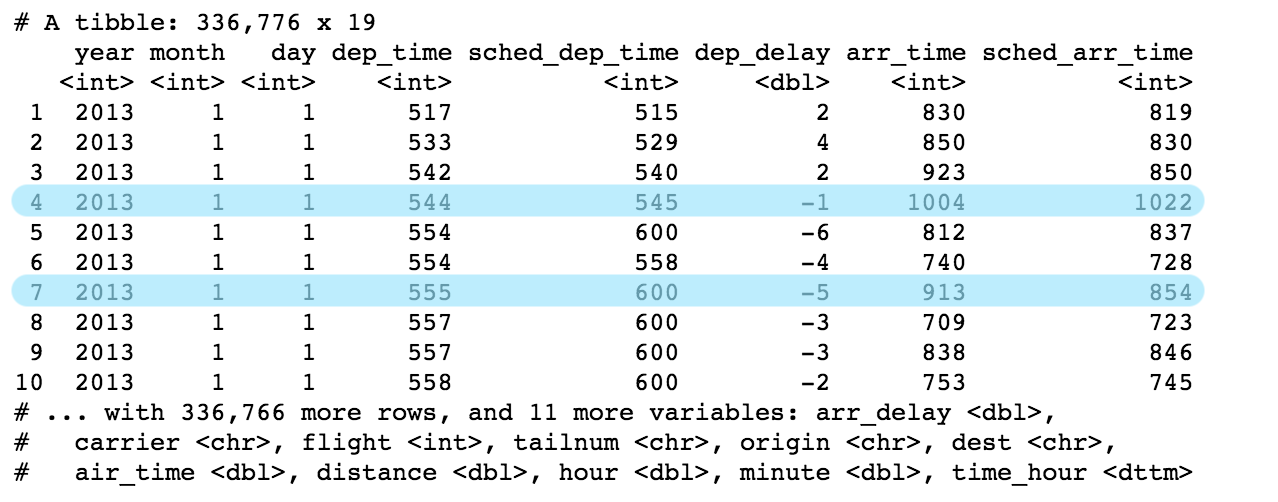

#### Select
`select()` selects columns
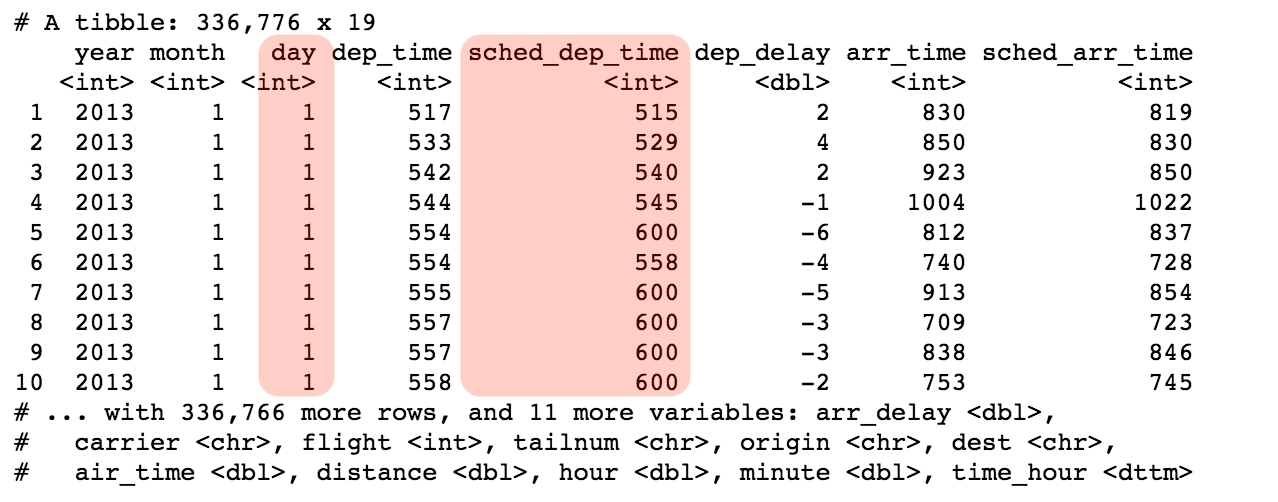

#### When to quote
Columns should not be quoted inside of commands like `filter()`. The following command returns an empty data table. Why? Because the condition evaluates to `FALSE`, which is then recycled up to every row of the table:

In [144]:
#filter(flights, "carrier" == "UA") %>% print  # wrong: compares the string "carrier" to the string "UA"
filter(flights, carrier == "UA") # produces an error: compares the column carrier to the (nonexistent) column UA
# correct: filter(flights, car rier == "UA") 

ERROR: Error in filter_impl(.data, quo): Evaluation error: object 'UA' not found.


#### `=` versus `==`
Remember that `=` and `==` mean different things. The former is used for assignment and to pass keyword parameters to functions. The latter is used to test for equality and returns either `TRUE` or `FALSE`.

In [150]:
#mutate(flights, carrier = "UA")  %>% select(carrier) %>% print
filter(flights, carrier == "UA")  ## error

      year month day dep_time sched_dep_time dep_delay arr_time sched_arr_time
1     2013 1     1   517      515             2         830      819          
2     2013 1     1   533      529             4         850      830          
3     2013 1     1   554      558            -4         740      728          
4     2013 1     1   558      600            -2         924      917          
5     2013 1     1   558      600            -2         923      937          
6     2013 1     1   559      600            -1         854      902          
7     2013 1     1   607      607             0         858      915          
8     2013 1     1   611      600            11         945      931          
9     2013 1     1   623      627            -4         933      932          
10    2013 1     1   628      630            -2        1016      947          
11    2013 1     1   643      646            -3         922      940          
12    2013 1     1   644      636             8     

#### Vector versus column versus data table
There is particular confusion about when it is appropriate to use vectors, columns and data tables. We will be discussing these concepts at greater length in the coming weeks, but here are some essentials that you should know:

**Vectors** in R contain multiple values. You create vectors using the `c()` function. If you do neglect to do this, R will produce an error and/or do the wrong thing. Some examples of this I saw include:
```{r}
a = factor(b, levels=1, 2, 3, 4, 5) ## wrong
a = factor(b, levels=(1, 2, 3, 4, 5)) ## wrong
a = factor(b, levels=c(1, 2, 3, 4, 5)) ## correct
```

Vectors have a particular type, and all the entries of the vector must be of that same type; if they are not R will convert them to be.

In [32]:
c(1,2,'a')  # conversion to string
c(T, T, factor('a'))  # conversion to int

[1] "1" "2" "a"

[1] 1 1 1

You can think of a data table as a list of vectors. Each column has its own vector. To access a vector of values stored in a column in R, we traditionally use the `$` operator:

In [156]:
class(select(flights, tailnum))
typeof(flights$tailnum)

[1] "tbl_df"     "tbl"        "data.frame"

[1] "character"

If working inside one of the `dplyr` functions like `mutate()`, `filter()`, etc., the dataset is specified by the first parameter. So you don't need to use the `$` operator, just specify the column name:
```{r}
filter(flights, flights$arr_delay < 10)  # wrong (although it will work)
filter(flights, arr_delay < 10)  # correct
```

Even though they contain the same information, a column vector is *not the same* as a table containing only that column:

In [34]:
head(flights$arr_time)  # <---- vector     
# is different from...
head(select(flights, arr_time)) # <---- data table

[1]  830  850  923 1004  812  740

  arr_time
1  830    
2  850    
3  923    
4 1004    
5  812    
6  740    

Passing in a data table where R expects a vector will lead to errors. For example, neither of the following are valid:
```{r}
month_factor = factor(flights)
month_factor = factor(select(flights, month))
```
These will take a large amount of time to run because R is creating a huge factor, one with a level for every observation in your data table.

### Some worked examples
Finally, we'll work through a few examples of how to put all of this together.

In [35]:
p = flights %>% mutate(on_time=arr_delay <= 0) %>% select(month, carrier, on_time) %>% 
    group_by(carrier, month) %>% summarize(on_time_pct=mean(on_time, na.rm=T), n=n()) %>% 
    ggplot(aes(x=factor(month), y=on_time_pct, group=carrier, color=carrier)) + 
    geom_line()

#### Plot the on-time arrival percentage by month for each airline

I want to make the following plot: one line per carrier. Twelve months of data. On the $y$-axis, the percentage of flights that arrived on time.

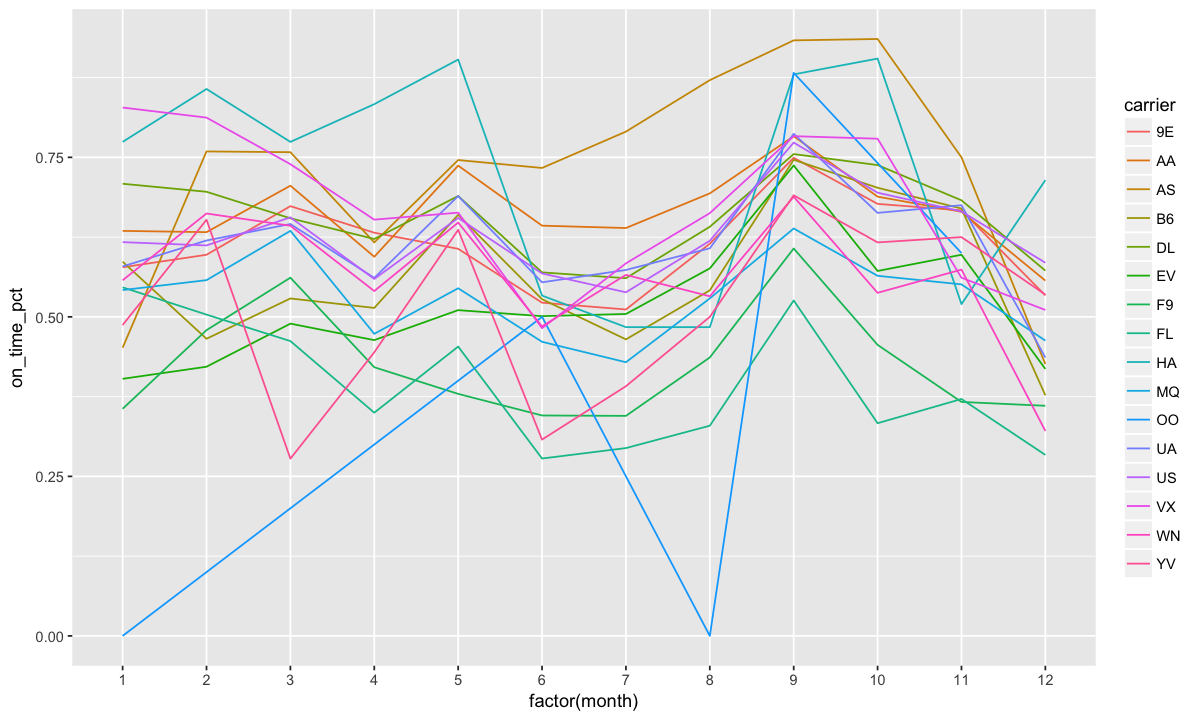

In [36]:
p

Step one will be to figure out how to compute on-time percentage. 

In [37]:
# 

In [38]:
ot = flights %>% mutate(on_time=arr_delay <= 0) %>% select(month, carrier, on_time) %>% print

# A tibble: 336,776 x 3
   month carrier on_time
   <int> <chr>   <lgl>  
 1     1 UA      FALSE  
 2     1 UA      FALSE  
 3     1 AA      FALSE  
 4     1 B6      TRUE   
 5     1 DL      TRUE   
 6     1 UA      FALSE  
 7     1 B6      FALSE  
 8     1 EV      TRUE   
 9     1 B6      TRUE   
10     1 AA      FALSE  
# ... with 336,766 more rows


In [39]:
ot = ot %>% group_by(carrier, month) %>%
            summarize(on_time_pct=mean(on_time, na.rm=T), n=n()) %>% print

# A tibble: 185 x 4
# Groups:   carrier [?]
   carrier month on_time_pct     n
   <chr>   <int>       <dbl> <int>
 1 9E          1       0.578  1573
 2 9E          2       0.597  1459
 3 9E          3       0.674  1627
 4 9E          4       0.632  1511
 5 9E          5       0.607  1462
 6 9E          6       0.522  1437
 7 9E          7       0.512  1494
 8 9E          8       0.615  1456
 9 9E          9       0.749  1540
10 9E         10       0.677  1673
# ... with 175 more rows


Step two is to use this new table to make the plot.

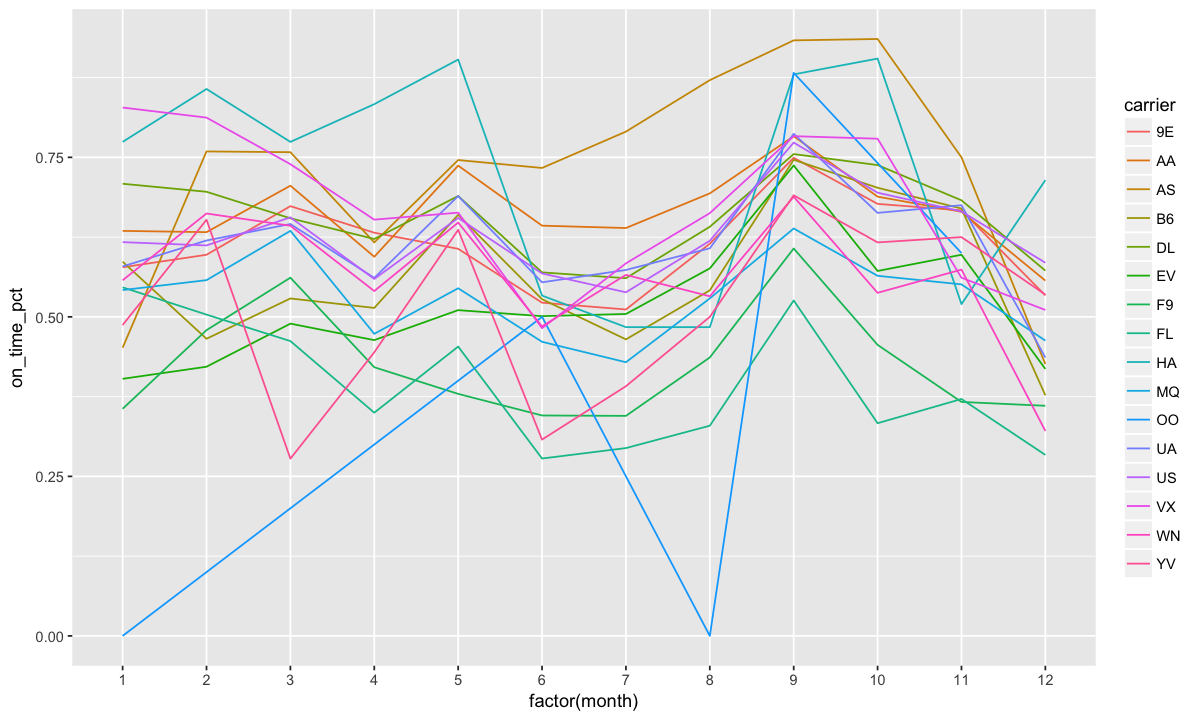

In [40]:
ot %>% ggplot(aes(x=factor(month), y=on_time_pct, group=carrier, color=carrier)) + 
       geom_line()

This is what we want, but is too busy. Let's filter down to only the carriers that have a pretty high number of observations.

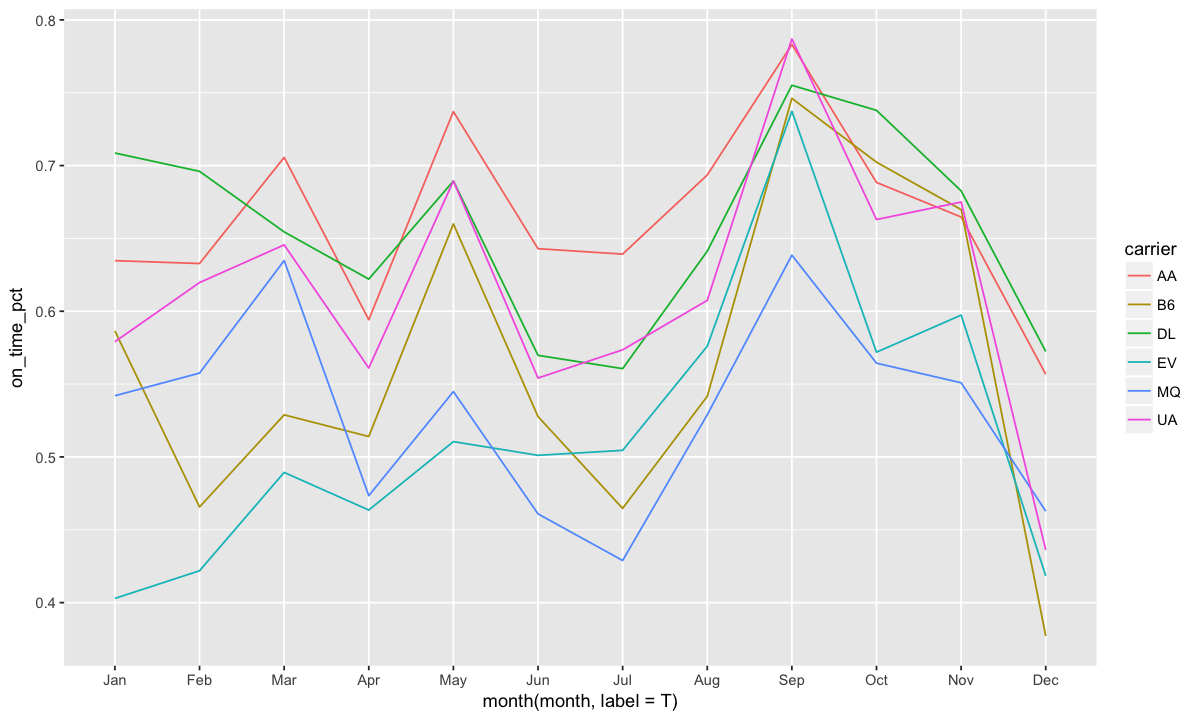

In [41]:
ot %>% filter(n > 2000) %>%  
       ggplot(aes(x=month(month, label=T), y=on_time_pct, group=carrier, color=carrier)) + 
       geom_line()

Finally, let's make the axis labels more readable.

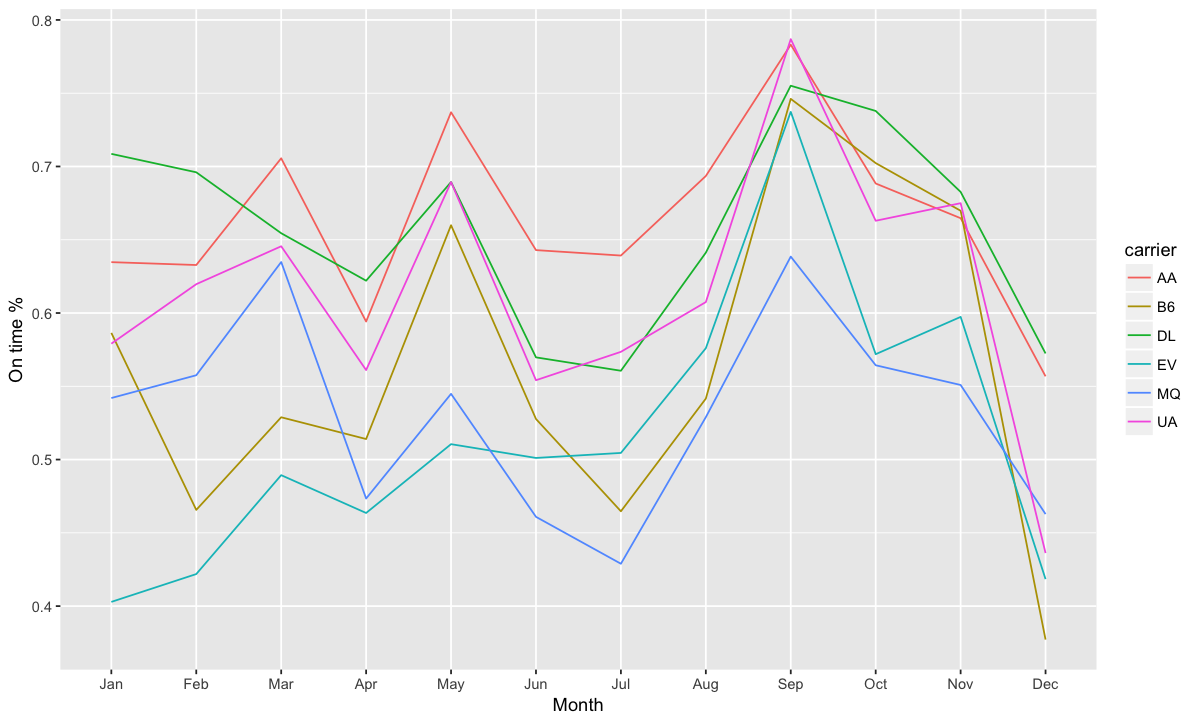

In [42]:
ot %>% filter(n > 2000) %>%  
       ggplot(aes(x=month(month, label=T), y=on_time_pct, group=carrier, color=carrier)) + 
       geom_line() + xlab('Month') + ylab("On time %")

#### Restrict to the top $k$ airlines
In the preceding example we narrowed down to an arbitrarily chosen threshold of `n>2000` in order to make the plot less cluttered. Let's do this in a data-driven manner by looking at what total share of observations are attribut

In [43]:
top_flights = flights %>% group_by(carrier) %>% count %>% arrange(n) %>% ungroup() %>% 
              mutate(cd=cumsum(n)/sum(n)) %>% print

# A tibble: 16 x 3
   carrier     n        cd
   <chr>   <int>     <dbl>
 1 OO         32 0.0000950
 2 HA        342 0.00111  
 3 YV        601 0.00290  
 4 F9        685 0.00493  
 5 AS        714 0.00705  
 6 FL       3260 0.0167   
 7 VX       5162 0.0321   
 8 WN      12275 0.0685   
 9 9E      18460 0.123    
10 US      20536 0.184    
11 MQ      26397 0.263    
12 AA      32729 0.360    
13 DL      48110 0.503    
14 EV      54173 0.664    
15 B6      54635 0.826    
16 UA      58665 1        


Almost 2/3rds of the flights are from the top six carriers, which happen to be the ones we chose in the earlier graph. So we can feel confident in our choice, knowing that there is plenty of support for it in the data.